# Library

In [1]:
# Installation
%pip install --quiet mesa

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import
import mesa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from tabulate import tabulate

import math
import random

# Class Definition

## Agent

In [209]:
class ChartistAgent(mesa.Agent):
    def __init__(self, id, model, fiat_owned, bitcoin_owned, chartist_day_reference):
        super().__init__(id, model)

        # Attribute Initialization         
        self.fiat = fiat_owned
        self.bitcoin = bitcoin_owned
        self.total_value_obtained = self.fiat + (self.bitcoin * self.model.price) - self.model.initial_fiat_owned
        self.is_close = True
        self.n = chartist_day_reference
        self.ratio_bitcoin_fiat = round(self.bitcoin * self.model.price / self.fiat, 2) if self.fiat > 0 else 0
        self.buy_price = 0
        
        # Default Rule : EMA for both opening and closing
        self.is_open_sma_high = False
        self.is_close_sma_high = False
        
        if (np.random.uniform() <= 0.25):
            # Rule : SMA for both opening and closing             
            self.is_open_sma_high = True
            self.is_close_sma_high = True
        elif (np.random.uniform() > 0.25 and np.random.uniform() < 0.5):
            # Rule : SMA for opening and EMA for closing
            self.is_open_sma_high = True
        elif (np.random.uniform() > 0.25 and np.random.uniform() < 0.75):
            # Rule : EMA for opening and SMA for closing
            self.is_close_sma_high = True
    
    def step(self):
        if self.is_close:
            # Potential Buy
            sma_value = self.calculate_sma_n_days()
            ema_value = self.calculate_ema_n_days()
            
            # Count Probability to Buy Based on Rule
            probability_to_buy = 0
            if self.model.price < sma_value:
                probability_to_buy += (0.8 if self.is_open_sma_high else 0.2)
            
            if self.model.price > ema_value:
                probability_to_buy += (0.8 if not self.is_open_sma_high else 0.2)
            
            # Actual Buy
            if (np.random.uniform() <= probability_to_buy):
                self.is_close = False
                
                bitcoin_obtained = math.floor((self.fiat / self.model.price) * 10000) / 10000
                self.bitcoin += bitcoin_obtained
                self.fiat -= self.bitcoin * self.model.price
                self.model.demand += bitcoin_obtained
                
                self.buy_price = self.model.price

                if (self.is_open_sma_high and self.is_close_sma_high):
                    self.model.number_of_open_position_R1R1_agent += 1
                elif (self.is_open_sma_high and not self.is_close_sma_high):
                    self.model.number_of_open_position_R1R2_agent += 1
                elif (not self.is_open_sma_high and self.is_close_sma_high):
                    self.model.number_of_open_position_R2R1_agent += 1
                elif (not self.is_open_sma_high and not self.is_close_sma_high):
                    self.model.number_of_open_position_R2R2_agent += 1
    
        else:
            # Potential Sell
            sma_value = self.calculate_sma_n_days()
            ema_value = self.calculate_ema_n_days()

            # Count Probability to Sell Based on Rule
            probability_to_sell = 0
            if self.model.price > sma_value:
                probability_to_sell += (0.8 if self.is_close_sma_high else 0.2)
            
            if self.model.price < ema_value:
                probability_to_sell += (0.8 if not self.is_close_sma_high else 0.2)
    
            
            # Actual Sell
            if (np.random.uniform() <= probability_to_sell):
                self.is_close = True
                
                bitcoin_released = self.bitcoin
                self.fiat += self.bitcoin * self.model.price
#                 if(self.model.steps > 1430 and self.model.steps < 1480):
#                     self.model.supply += self.bitcoin * self.model.price
                self.model.supply += bitcoin_released
                self.bitcoin -= bitcoin_released

                
                self.buy_price = 0
                
                if (self.is_open_sma_high and self.is_close_sma_high):
                    self.model.number_of_open_position_R1R1_agent -= 1
                elif (self.is_open_sma_high and not self.is_close_sma_high):
                    self.model.number_of_open_position_R1R2_agent -= 1
                elif (not self.is_open_sma_high and self.is_close_sma_high):
                    self.model.number_of_open_position_R2R1_agent -= 1
                elif (not self.is_open_sma_high and not self.is_close_sma_high):
                    self.model.number_of_open_position_R2R2_agent -= 1
        
        self.total_value_obtained = self.fiat + (self.bitcoin * self.model.price) - self.model.initial_fiat_owned
        self.ratio_bitcoin_fiat = round(self.bitcoin * self.model.price / self.fiat, 2) if self.fiat > 0 else 0
                    
    # Agent Helper Function
    # SMA Rule
    def calculate_sma_n_days(self):
        start_index = max(0, len(self.model.price_history) - self.n)
        window = self.model.price_history[start_index:len(self.model.price_history)]

        return sum(window) / len(window)

    # EMA Rule
    def calculate_ema_n_days(self):
        smooth_factor = 2 / (self.n + 1)
        
        last_n_price = pd.Series(self.model.price_history[len(self.model.price_history) - self.n:])
        
        ema = last_n_price.ewm(alpha=smooth_factor, adjust=False).mean()

        return float(ema.tail(1))

In [210]:
class RandomAgent(mesa.Agent):
    def __init__(self, id, model, fiat_owned, bitcoin_owned):
        super().__init__(id, model)

        # Attribute Initialization         
        self.fiat = fiat_owned
        self.bitcoin = bitcoin_owned
        self.total_value_obtained = self.fiat + (self.bitcoin * self.model.price) - self.model.initial_fiat_owned
        self.is_close = True
        self.ratio_bitcoin_fiat = round(self.bitcoin * self.model.price / self.fiat, 2) if self.fiat > 0 else 0
    
    def step(self):
        if self.is_close:
            # Actual Buy
            if (np.random.uniform() <= 0.5):
                self.is_close = False

                bitcoin_obtained = math.floor((self.fiat / self.model.price) * 10000) / 10000
                self.bitcoin += bitcoin_obtained
                self.fiat -= self.bitcoin * self.model.price
                self.model.demand += bitcoin_obtained
                self.model.number_of_open_position_random_agent += 1
    
        else:
            # Actual Sell
            if (np.random.uniform() <= 0.5):
                self.is_close = True
                
                bitcoin_released = self.bitcoin
                self.fiat += self.bitcoin * self.model.price
                
#                 if(self.model.steps > 1430 and self.model.steps < 1480):
#                     self.model.supply += self.bitcoin * self.model.price
                self.model.supply += bitcoin_released
                
                self.bitcoin -= bitcoin_released


                self.model.number_of_open_position_random_agent -= 1

        self.total_value_obtained = self.fiat + (self.bitcoin * self.model.price) - self.model.initial_fiat_owned
        self.ratio_bitcoin_fiat = round(self.bitcoin * self.model.price / self.fiat, 2) if self.fiat > 0 else 0
        

In [211]:
import random

class BitcoinMarketModel(mesa.Model):
    def __init__(self, chartist_day_reference):
        self.schedule = mesa.time.RandomActivation(self)
        
        # Init
        price_start = 5614
        self.price = price_start
        self.price_history = [price_start]
        self.number_of_agents = 56 
        
        self.total_fiat = 70056
        self.total_bitcoin = 54.4249
        self.supply = 0
        self.demand = 0
        
        self.number_of_open_position_R1R1_agent = 0
        self.number_of_open_position_R1R2_agent = 0
        self.number_of_open_position_R2R1_agent = 0
        self.number_of_open_position_R2R2_agent = 0
        self.number_of_open_position_random_agent = 0

        # For Intermediary Process
        self.steps = 0
        self.agents = []
        
        self.chartist_ratio = 0.6
        self.initial_fiat_owned = self.total_fiat / self.number_of_agents
        self.chartist_day_reference = chartist_day_reference
        
        # For Batch Run         
        self.running = True
        
        number_of_chartist = math.floor(self.chartist_ratio * self.number_of_agents)
        number_of_random = self.number_of_agents - number_of_chartist
        fiat_owned = self.initial_fiat_owned
        bitcoin_owned = 0

        for i in range(number_of_chartist):
            a = ChartistAgent(str(f"chartist-{i}"), 
                              self, 
                              fiat_owned,
                              bitcoin_owned, 
                              chartist_day_reference)

            self.schedule.add(a)
            self.agents.append(a)
        
        for i in range(number_of_random):
            a = RandomAgent(str(f"random-{i}"), 
                          self, 
                          fiat_owned,
                          bitcoin_owned)

            self.schedule.add(a)
            self.agents.append(a)
        
        self.datacollector = mesa.DataCollector(
            model_reporters={"Price": "price", 
                             "Number_of_agents": "number_of_agents", 
                             "Open_R1R1": "number_of_open_position_R1R1_agent", 
                             "Open_R1R2": "number_of_open_position_R1R2_agent", 
                             "Open_R2R1": "number_of_open_position_R2R1_agent", 
                             "Open_R2R2": "number_of_open_position_R2R2_agent", 
                             "Open_Random": "number_of_open_position_random_agent"}, 
            agent_reporters={"Fiat": "fiat", 
                             "Bitcoin": "bitcoin", 
                             "TOV": "total_value_obtained", 
                             "RBF": "ratio_bitcoin_fiat",
                             "OpenSMA": "is_open_sma_high", 
                             "CloseSMA": "is_close_sma_high"}
        )
    
    def step(self):
        # Before Stepping
#         print(f'old price {self.price}')
#         print(f'supply : { self.supply }')
#         print(f'demand : { self.demand }')
        self.price += self.calculate_today_price_change()
#         print(f'new price {self.price}')
        self.supply = 0
        self.demand = 0
        
        self.datacollector.collect(self)
        
        # Stepping
        self.schedule.step()
        self.steps += 1
        
        # After Stepping
        self.price_history.append(self.price)
        
        # Monthly Adjustment
        if (self.steps % 30 == 0):
            # Add New Agents
            old_number_of_agents = self.number_of_agents
            self.number_of_agents += math.floor(0.02 * self.number_of_agents)
            
            number_of_chartist = math.floor(self.chartist_ratio * self.number_of_agents)
            number_of_random = self.number_of_agents - number_of_chartist
            fiat_owned = self.initial_fiat_owned
            bitcoin_owned = 0
            chartist_day_reference = self.chartist_day_reference
            
            for i in range(number_of_chartist):
                a = ChartistAgent(str(f"add-chartist-{i}-at-{self.steps}"), 
                                  self, 
                                  fiat_owned,
                                  bitcoin_owned, 
                                  chartist_day_reference)

                self.schedule.add(a)
                self.agents.append(a)

            for i in range(number_of_random):
                a = RandomAgent(str(f"add-random-{i}-at-{self.steps}"), 
                              self, 
                              fiat_owned,
                              bitcoin_owned)

                self.schedule.add(a)
                self.agents.append(a)
                    
            # Add New Bitcoins to Traders
            valuable_agents = []
            total_value_in_agents = 0
            for i in range(len(self.agents)):
                agent = self.agents[i]
                total_value_in_agents += agent.total_value_obtained
                
                if (np.random.uniform() <= 0.5):
                    valuable_agents.append(agent)

            
            total_new_bitcoin = round(0.076 * self.total_bitcoin, 4)
            self.total_bitcoin += total_new_bitcoin
            
            for i in range(len(valuable_agents)):
                agent = valuable_agents[i]
                
                ratio = agent.total_value_obtained / total_value_in_agents
                
                agent.bitcoin += round(ratio * total_new_bitcoin, 4)
        
        # Attack on 1st December
        if (self.steps == 1430):
#             print(f'MASUK')
#             print(f'price {self.price}')
#             print(f'number of agent {self.number_of_agents}')
            old_number_of_agents = self.number_of_agents
            self.number_of_agents -= math.floor(0.4 * self.number_of_agents)
            
#             print(f'number of agent new {self.number_of_agents}')
            
            number_of_agents_deleted = old_number_of_agents - self.number_of_agents
            
#             print(f'need to delete {number_of_agents_deleted} agents')
            
            total_bitcoin_sold = 0
            
            for i in range(number_of_agents_deleted):
                selected_agent = random.choice(self.agents)
                
#                 print(f'chosen agent {selected_agent.unique_id}')
#                 print(f'bitcoin {selected_agent.bitcoin}')
                
                total_bitcoin_sold += selected_agent.bitcoin
                
                self.remove_agent(selected_agent)
                self.agents.remove(selected_agent)
            
#             print(f'total bitcoin sold : {total_bitcoin_sold}')
#             print(f'initial supply : { self.supply }')
#             self.supply += total_bitcoin_sold * self.price + self.demand * 400
            self.supply += total_bitcoin_sold * self.price
#             print(f'new supply : { self.supply }')
#             print(f'demand : { self.demand }')
        
    # Model Helper Function
    # Calculate Price
    def calculate_today_price_change(self):
        supply_demand_difference = self.demand - self.supply
        sign = math.copysign(1, supply_demand_difference)
        result = math.floor((math.sqrt(2) / 2) *  math.sqrt(abs(supply_demand_difference))) * sign
        
        return result
    
    # Remove Agent
    def remove_agent(self, agent):
        self.schedule.remove(agent)

# Task 2 SIMULATION

In [6]:
# Agents Parameters
params = {"chartist_day_reference": [1,2,3,5,7,9]}

max_steps = 1400

results = mesa.batch_run(
    BitcoinMarketModel,
    parameters=params,
    iterations=2,
    number_processes=1,
    max_steps=max_steps,
    data_collection_period=3,
    display_progress=True,
)

results_df = pd.DataFrame(results)
# print(results_df)

  0%|          | 0/12 [00:00<?, ?it/s]

## Task 2.1 Effect of n in Chartist Strategy

In [7]:
results_chartist_df = results_df[(results_df["AgentID"].str.contains("chartist"))]
results_chartist_df = results_chartist_df[(results_chartist_df.Step == max_steps)]

# print(results_chartist_df)

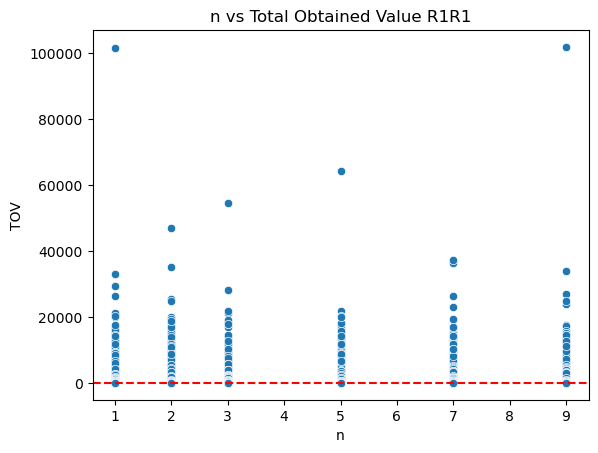

                           TOV Mean       TOV SD      TOV Max  TOV Min
chartist_day_reference                                                
1                       1721.749308  4291.385967  101596.9254   3.0032
2                       1812.675550  3359.999605   46960.5489   0.0000
3                       1701.623672  3260.806020   54496.4885   0.0000
5                       1667.931205  3286.556426   64210.7660   1.7226
7                       1722.251761  3152.470271   37293.8680   0.0000
9                       1845.483324  4233.137913  101782.1495   0.0000


                        Open Pos Mean  Open Pos SD
chartist_day_reference                            
1                          112.900000     2.999649
2                          107.476316     4.501913
3                          103.493827     0.500182
5                          104.064220     5.001883
7                          107.547597     3.501264
9                          124.635539     6.501535


In [8]:
results_chartist_R1R1_df = results_chartist_df[(results_chartist_df.OpenSMA == True)]
results_chartist_R1R1_df = results_chartist_R1R1_df[(results_chartist_R1R1_df.CloseSMA == True)]

g_R1R1 = sns.scatterplot(data=results_chartist_R1R1_df, 
               x="chartist_day_reference", 
               y="TOV")
g_R1R1.set(
    xlabel="n",
    ylabel="TOV",
    title="n vs Total Obtained Value R1R1",
);

plt.axhline(y=0, color='r', linestyle='--', label='y=0')
plt.show()

avg_TVO_per_n_R1R1_df = pd.DataFrame(results_chartist_R1R1_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['TOV'])
avg_TVO_per_n_R1R1_df = avg_TVO_per_n_R1R1_df.rename(columns={'TOV': 'TOV Mean'})
sd_TVO_per_n_R1R1_df = pd.DataFrame(results_chartist_R1R1_df.groupby(['chartist_day_reference']).std(numeric_only=True)['TOV'])
sd_TVO_per_n_R1R1_df = sd_TVO_per_n_R1R1_df.rename(columns={'TOV': 'TOV SD'})
max_TVO_per_n_R1R1_df = pd.DataFrame(results_chartist_R1R1_df.groupby(['chartist_day_reference']).max(numeric_only=True)['TOV'])
max_TVO_per_n_R1R1_df = max_TVO_per_n_R1R1_df.rename(columns={'TOV': 'TOV Max'})
min_TVO_per_n_R1R1_df = pd.DataFrame(results_chartist_R1R1_df.groupby(['chartist_day_reference']).min(numeric_only=True)['TOV'])
min_TVO_per_n_R1R1_df = min_TVO_per_n_R1R1_df.rename(columns={'TOV': 'TOV Min'})

aggregated_TVO_per_n_R1R1_df = avg_TVO_per_n_R1R1_df.merge(sd_TVO_per_n_R1R1_df, on='chartist_day_reference', how='left')
aggregated_TVO_per_n_R1R1_df = aggregated_TVO_per_n_R1R1_df.merge(max_TVO_per_n_R1R1_df, on='chartist_day_reference', how='left')
aggregated_TVO_per_n_R1R1_df = aggregated_TVO_per_n_R1R1_df.merge(min_TVO_per_n_R1R1_df, on='chartist_day_reference', how='left')

avg_open_pos_per_n_R1R1_df = pd.DataFrame(results_chartist_R1R1_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['Open_R1R1'])
avg_open_pos_per_n_R1R1_df = avg_open_pos_per_n_R1R1_df.rename(columns={'Open_R1R1': 'Open Pos Mean'})
sd_open_pos_per_n_R1R1_df = pd.DataFrame(results_chartist_R1R1_df.groupby(['chartist_day_reference']).std(numeric_only=True)['Open_R1R1'])
sd_open_pos_per_n_R1R1_df = sd_open_pos_per_n_R1R1_df.rename(columns={'Open_R1R1': 'Open Pos SD'})

print(aggregated_TVO_per_n_R1R1_df)
print('\n')
print(avg_open_pos_per_n_R1R1_df.merge(sd_open_pos_per_n_R1R1_df, on='chartist_day_reference',how='left'))


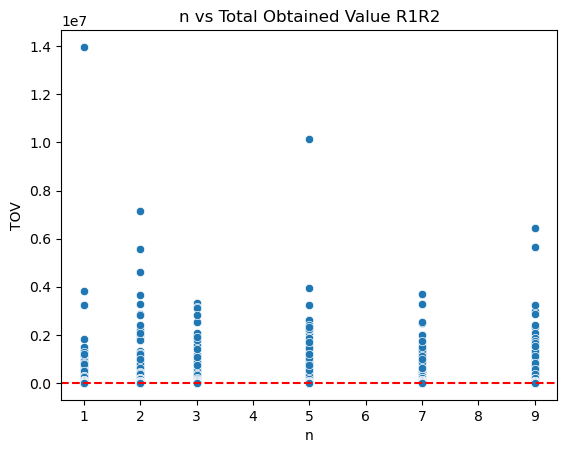

                            TOV Mean         TOV SD       TOV Max  TOV Min
chartist_day_reference                                                    
1                       75451.815692  463328.369540  1.397118e+07   0.0000
2                       92080.286880  403870.976652  7.128729e+06   0.0000
3                       86945.587797  306343.301688  3.316382e+06   7.6008
5                       82900.865520  404840.349455  1.014849e+07   0.0000
7                       68443.782788  261224.492879  3.703200e+06   2.8498
9                       80874.040623  354678.365705  6.421329e+06   9.2734


                        Open Pos Mean  Open Pos SD
chartist_day_reference                            
1                          286.180426    19.496423
2                          307.132510     7.001628
3                          305.041152     2.000400
5                          311.336554    14.504919
7                          295.609555     9.503283
9                          301.105600    

In [9]:
results_chartist_R1R2_df = results_chartist_df[(results_chartist_df.OpenSMA == True)]
results_chartist_R1R2_df = results_chartist_R1R2_df[(results_chartist_R1R2_df.CloseSMA == False)]

g_R1R2 = sns.scatterplot(data=results_chartist_R1R2_df, 
               x="chartist_day_reference", 
               y="TOV")
g_R1R2.set(
    xlabel="n",
    ylabel="TOV",
    title="n vs Total Obtained Value R1R2",
);

plt.axhline(y=0, color='r', linestyle='--', label='y=0')
plt.show()

avg_TVO_per_n_R1R2_df = pd.DataFrame(results_chartist_R1R2_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['TOV'])
avg_TVO_per_n_R1R2_df = avg_TVO_per_n_R1R2_df.rename(columns={'TOV': 'TOV Mean'})
sd_TVO_per_n_R1R2_df = pd.DataFrame(results_chartist_R1R2_df.groupby(['chartist_day_reference']).std(numeric_only=True)['TOV'])
sd_TVO_per_n_R1R2_df = sd_TVO_per_n_R1R2_df.rename(columns={'TOV': 'TOV SD'})
max_TVO_per_n_R1R2_df = pd.DataFrame(results_chartist_R1R2_df.groupby(['chartist_day_reference']).max(numeric_only=True)['TOV'])
max_TVO_per_n_R1R2_df = max_TVO_per_n_R1R2_df.rename(columns={'TOV': 'TOV Max'})
min_TVO_per_n_R1R2_df = pd.DataFrame(results_chartist_R1R2_df.groupby(['chartist_day_reference']).min(numeric_only=True)['TOV'])
min_TVO_per_n_R1R2_df = min_TVO_per_n_R1R2_df.rename(columns={'TOV': 'TOV Min'})

aggregated_TVO_per_n_R1R2_df = avg_TVO_per_n_R1R2_df.merge(sd_TVO_per_n_R1R2_df, on='chartist_day_reference', how='left')
aggregated_TVO_per_n_R1R2_df = aggregated_TVO_per_n_R1R2_df.merge(max_TVO_per_n_R1R2_df, on='chartist_day_reference', how='left')
aggregated_TVO_per_n_R1R2_df = aggregated_TVO_per_n_R1R2_df.merge(min_TVO_per_n_R1R2_df, on='chartist_day_reference', how='left')

avg_open_pos_per_n_R1R2_df = pd.DataFrame(results_chartist_R1R2_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['Open_R1R2'])
avg_open_pos_per_n_R1R2_df = avg_open_pos_per_n_R1R2_df.rename(columns={'Open_R1R2': 'Open Pos Mean'})
sd_open_pos_per_n_R1R2_df = pd.DataFrame(results_chartist_R1R2_df.groupby(['chartist_day_reference']).std(numeric_only=True)['Open_R1R2'])
sd_open_pos_per_n_R1R2_df = sd_open_pos_per_n_R1R2_df.rename(columns={'Open_R1R2': 'Open Pos SD'})

print(aggregated_TVO_per_n_R1R2_df)
print('\n')
print(avg_open_pos_per_n_R1R2_df.merge(sd_open_pos_per_n_R1R2_df, on='chartist_day_reference',how='left'))

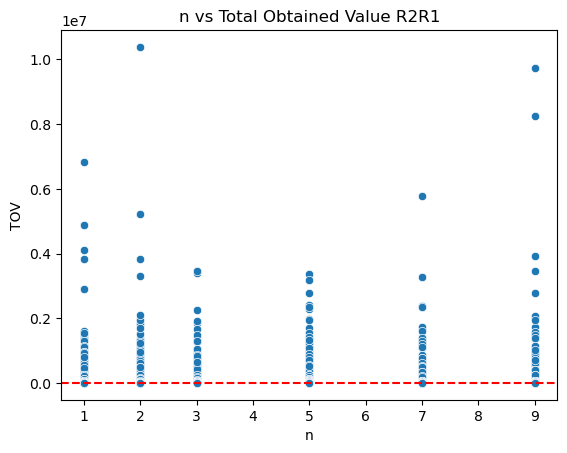

                            TOV Mean         TOV SD       TOV Max  TOV Min
chartist_day_reference                                                    
1                       81966.276863  350512.753905  6.824788e+06  19.5800
2                       82504.895723  419195.851180  1.038462e+07  22.4320
3                       66458.375922  244189.684354  3.473314e+06  19.0600
5                       71770.092148  267712.300514  3.355093e+06  15.1506
7                       69449.351370  283508.095433  5.792554e+06  17.8018
9                       85605.400306  455970.810841  9.734126e+06  20.4803


                        Open Pos Mean  Open Pos SD
chartist_day_reference                            
1                          302.488980     1.500572
2                          277.320104    29.983879
3                          291.040541     6.002398
5                          284.000000     0.000000
7                          297.837746    10.002956
9                          285.893196    

In [10]:
results_chartist_R2R1_df = results_chartist_df[(results_chartist_df.OpenSMA == False)]
results_chartist_R2R1_df = results_chartist_R2R1_df[(results_chartist_R2R1_df.CloseSMA == True)]

g_R2R1 = sns.scatterplot(data=results_chartist_R2R1_df, 
               x="chartist_day_reference", 
               y="TOV")
g_R2R1.set(
    xlabel="n",
    ylabel="TOV",
    title="n vs Total Obtained Value R2R1",
);

plt.axhline(y=0, color='r', linestyle='--', label='y=0')
plt.show()

avg_TVO_per_n_R2R1_df = pd.DataFrame(results_chartist_R2R1_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['TOV'])
avg_TVO_per_n_R2R1_df = avg_TVO_per_n_R2R1_df.rename(columns={'TOV': 'TOV Mean'})
sd_TVO_per_n_R2R1_df = pd.DataFrame(results_chartist_R2R1_df.groupby(['chartist_day_reference']).std(numeric_only=True)['TOV'])
sd_TVO_per_n_R2R1_df = sd_TVO_per_n_R2R1_df.rename(columns={'TOV': 'TOV SD'})
max_TVO_per_n_R2R1_df = pd.DataFrame(results_chartist_R2R1_df.groupby(['chartist_day_reference']).max(numeric_only=True)['TOV'])
max_TVO_per_n_R2R1_df = max_TVO_per_n_R2R1_df.rename(columns={'TOV': 'TOV Max'})
min_TVO_per_n_R2R1_df = pd.DataFrame(results_chartist_R2R1_df.groupby(['chartist_day_reference']).min(numeric_only=True)['TOV'])
min_TVO_per_n_R2R1_df = min_TVO_per_n_R2R1_df.rename(columns={'TOV': 'TOV Min'})

aggregated_TVO_per_n_R2R1_df = avg_TVO_per_n_R2R1_df.merge(sd_TVO_per_n_R2R1_df, on='chartist_day_reference', how='left')
aggregated_TVO_per_n_R2R1_df = aggregated_TVO_per_n_R2R1_df.merge(max_TVO_per_n_R2R1_df, on='chartist_day_reference', how='left')
aggregated_TVO_per_n_R2R1_df = aggregated_TVO_per_n_R2R1_df.merge(min_TVO_per_n_R2R1_df, on='chartist_day_reference', how='left')

avg_open_pos_per_n_R2R1_df = pd.DataFrame(results_chartist_R2R1_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['Open_R2R1'])
avg_open_pos_per_n_R2R1_df = avg_open_pos_per_n_R2R1_df.rename(columns={'Open_R2R1': 'Open Pos Mean'})
sd_open_pos_per_n_R2R1_df = pd.DataFrame(results_chartist_R2R1_df.groupby(['chartist_day_reference']).std(numeric_only=True)['Open_R2R1'])
sd_open_pos_per_n_R2R1_df = sd_open_pos_per_n_R2R1_df.rename(columns={'Open_R2R1': 'Open Pos SD'})

print(aggregated_TVO_per_n_R2R1_df)
print('\n')
print(avg_open_pos_per_n_R2R1_df.merge(sd_open_pos_per_n_R2R1_df, on='chartist_day_reference',how='left'))

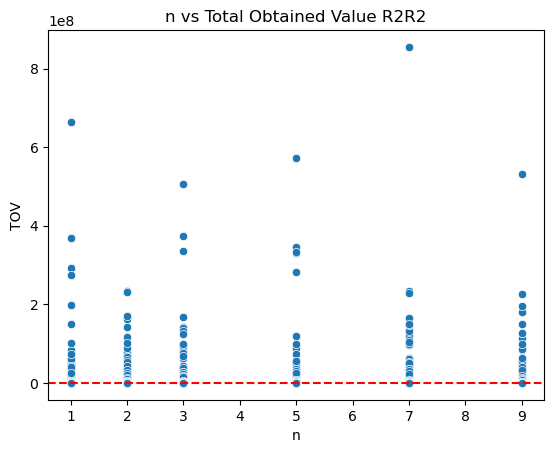

                            TOV Mean        TOV SD       TOV Max  TOV Min
chartist_day_reference                                                   
1                       4.031068e+06  3.097225e+07  6.635893e+08  24.5672
2                       3.579018e+06  1.732378e+07  2.351739e+08  33.3420
3                       4.256796e+06  2.778561e+07  5.066750e+08  32.4716
5                       4.286362e+06  3.034275e+07  5.721206e+08  26.2304
7                       4.537373e+06  3.322600e+07  8.550811e+08  26.8778
9                       3.629727e+06  2.385193e+07  5.309796e+08  28.4252


                        Open Pos Mean  Open Pos SD
chartist_day_reference                            
1                          353.993197     1.000544
2                          370.546256    33.923207
3                          344.474691     7.504179
5                          359.518560     1.500729
7                          354.481799    25.008749
9                          360.295154    27.98544

In [11]:
results_chartist_R2R2_df = results_chartist_df[(results_chartist_df.OpenSMA == False)]
results_chartist_R2R2_df = results_chartist_R2R2_df[(results_chartist_R2R2_df.CloseSMA == False)]

g_R2R2 = sns.scatterplot(data=results_chartist_R2R2_df, 
               x="chartist_day_reference", 
               y="TOV")
g_R2R2.set(
    xlabel="n",
    ylabel="TOV",
    title="n vs Total Obtained Value R2R2",
);

plt.axhline(y=0, color='r', linestyle='--', label='y=0')
plt.show()

avg_TVO_per_n_R2R2_df = pd.DataFrame(results_chartist_R2R2_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['TOV'])
avg_TVO_per_n_R2R2_df = avg_TVO_per_n_R2R2_df.rename(columns={'TOV': 'TOV Mean'})
sd_TVO_per_n_R2R2_df = pd.DataFrame(results_chartist_R2R2_df.groupby(['chartist_day_reference']).std(numeric_only=True)['TOV'])
sd_TVO_per_n_R2R2_df = sd_TVO_per_n_R2R2_df.rename(columns={'TOV': 'TOV SD'})
max_TVO_per_n_R2R2_df = pd.DataFrame(results_chartist_R2R2_df.groupby(['chartist_day_reference']).max(numeric_only=True)['TOV'])
max_TVO_per_n_R2R2_df = max_TVO_per_n_R2R2_df.rename(columns={'TOV': 'TOV Max'})
min_TVO_per_n_R2R2_df = pd.DataFrame(results_chartist_R2R2_df.groupby(['chartist_day_reference']).min(numeric_only=True)['TOV'])
min_TVO_per_n_R2R2_df = min_TVO_per_n_R2R2_df.rename(columns={'TOV': 'TOV Min'})

aggregated_TVO_per_n_R2R2_df = avg_TVO_per_n_R2R2_df.merge(sd_TVO_per_n_R2R2_df, on='chartist_day_reference', how='left')
aggregated_TVO_per_n_R2R2_df = aggregated_TVO_per_n_R2R2_df.merge(max_TVO_per_n_R2R2_df, on='chartist_day_reference', how='left')
aggregated_TVO_per_n_R2R2_df = aggregated_TVO_per_n_R2R2_df.merge(min_TVO_per_n_R2R2_df, on='chartist_day_reference', how='left')

avg_open_pos_per_n_R2R2_df = pd.DataFrame(results_chartist_R2R2_df.groupby(['chartist_day_reference']).mean(numeric_only=True)['Open_R2R2'])
avg_open_pos_per_n_R2R2_df = avg_open_pos_per_n_R2R2_df.rename(columns={'Open_R2R2': 'Open Pos Mean'})
sd_open_pos_per_n_R2R2_df = pd.DataFrame(results_chartist_R2R2_df.groupby(['chartist_day_reference']).std(numeric_only=True)['Open_R2R2'])
sd_open_pos_per_n_R2R2_df = sd_open_pos_per_n_R2R2_df.rename(columns={'Open_R2R2': 'Open Pos SD'})

print(aggregated_TVO_per_n_R2R2_df)
print('\n')
print(avg_open_pos_per_n_R2R2_df.merge(sd_open_pos_per_n_R2R2_df, on='chartist_day_reference',how='left'))

## Task 2.2 Agent Comparisons

In [23]:
best_n_R1R1 = 9
best_n_R1R2 = 2
best_n_R2R1 = 9
best_n_R2R2 = 7

results_chartist_R1R1__best_n_df = results_chartist_R1R1_df[(results_chartist_R1R1_df.chartist_day_reference == best_n_R1R1)]
results_chartist_R1R2__best_n_df = results_chartist_R1R2_df[(results_chartist_R1R2_df.chartist_day_reference == best_n_R1R2)]
results_chartist_R2R1__best_n_df = results_chartist_R2R1_df[(results_chartist_R2R1_df.chartist_day_reference == best_n_R2R1)]
results_chartist_R2R2__best_n_df = results_chartist_R2R2_df[(results_chartist_R2R2_df.chartist_day_reference == best_n_R2R2)]

results_random_df = results_df[(results_df["AgentID"].str.contains("random"))]
results_random_df = results_random_df[(results_random_df.Step == max_steps)]
results_random_best_n_df = results_random_df[(results_random_df.chartist_day_reference == best_n_R1R1)]

# print(results_chartist_R1R1__best_n_df.head(3))

In [30]:
print('TOV Statistics')
summary_TOV = pd.DataFrame({
    'Agent Name': ['R1R1','R1R2','R2R1', 'R2R2', 'Random'],
    'Avg': [results_chartist_R1R1__best_n_df.mean(numeric_only=True)['TOV'],
           results_chartist_R1R2__best_n_df.mean(numeric_only=True)['TOV'],
           results_chartist_R2R1__best_n_df.mean(numeric_only=True)['TOV'],
           results_chartist_R2R2__best_n_df.mean(numeric_only=True)['TOV'],
           results_random_best_n_df.mean(numeric_only=True)['TOV']],
    'SD': [results_chartist_R1R1__best_n_df.std(numeric_only=True)['TOV'],
           results_chartist_R1R2__best_n_df.std(numeric_only=True)['TOV'],
           results_chartist_R2R1__best_n_df.std(numeric_only=True)['TOV'],
           results_chartist_R2R2__best_n_df.std(numeric_only=True)['TOV'],
           results_random_best_n_df.std(numeric_only=True)['TOV']]
})
print(summary_TOV)

fig = px.histogram(summary_TOV, x="Agent Name" , y=["Avg", "SD"], log_y=True, opacity=0.7, barmode='overlay',
                   facet_col='variable',
                   title='Histogram for TOV Avg and SD',
                   labels={'value': 'Value', 'variable': 'Columns'})

fig.update_yaxes(minor=dict(ticks="inside", ticklen=6, showgrid=True))

fig.show()

TOV Statistics
  Agent Name           Avg            SD
0       R1R1  1.845483e+03  4.233138e+03
1       R1R2  9.208029e+04  4.038710e+05
2       R2R1  8.560540e+04  4.559708e+05
3       R2R2  4.537373e+06  3.322600e+07
4     Random  8.077220e+04  4.251428e+05


In [33]:
print('Open Position Statistics')
summary_open_pos = pd.DataFrame({
    'Agent Name': ['R1R1','R1R2','R2R1', 'R2R2', 'Random'],
    'Avg': [results_chartist_R1R1__best_n_df.mean(numeric_only=True)['Open_R1R1'], 
            results_chartist_R1R2__best_n_df.mean(numeric_only=True)['Open_R1R2'],
            results_chartist_R2R1__best_n_df.mean(numeric_only=True)['Open_R2R1'], 
            results_chartist_R2R2__best_n_df.mean(numeric_only=True)['Open_R2R2'], 
            results_random_best_n_df.mean(numeric_only=True)['Open_Random']],
    'SD': [results_chartist_R1R1__best_n_df.std(numeric_only=True)['Open_R1R1'],
           results_chartist_R1R2__best_n_df.std(numeric_only=True)['Open_R1R2'],
           results_chartist_R2R1__best_n_df.std(numeric_only=True)['Open_R2R1'],
           results_chartist_R2R2__best_n_df.std(numeric_only=True)['Open_R2R2'],  
           results_random_best_n_df.std(numeric_only=True)['Open_Random']]
})
print(summary_open_pos)

fig = px.histogram(summary_open_pos, x="Agent Name" , y=["Avg", "SD"], opacity=0.7, barmode='overlay',
                   facet_col='variable',
                   title='Histogram for Open Position Avg and SD',
                   labels={'value': 'Value', 'variable': 'Columns'})

fig.update_yaxes(minor=dict(ticks="inside", ticklen=6, showgrid=True))

fig.show()

Open Position Statistics
  Agent Name         Avg         SD
0       R1R1  124.635539   6.501535
1       R1R2  307.132510   7.001628
2       R2R1  285.893196   4.000297
3       R2R2  354.481799  25.008749
4     Random  779.000000   5.000831


In [48]:
print('Ratio Bitcoin vs Fiat')
bitcoin_price_at_the_end = 4635116 # this is because I forget to add this factor when calculating RBF in the model
summary_ratio = pd.DataFrame({
    'Agent Name': ['R1R1','R1R2','R2R1', 'R2R2', 'Random'],
    'Avg': [results_chartist_R1R1__best_n_df.mean(numeric_only=True)['RBF'] * bitcoin_price_at_the_end,
           results_chartist_R1R2__best_n_df.mean(numeric_only=True)['RBF'] * bitcoin_price_at_the_end,
           results_chartist_R2R1__best_n_df.mean(numeric_only=True)['RBF'] * bitcoin_price_at_the_end,
           results_chartist_R2R2__best_n_df.mean(numeric_only=True)['RBF'] * bitcoin_price_at_the_end,
           results_random_best_n_df.mean(numeric_only=True)['RBF'] * bitcoin_price_at_the_end],
    'SD': [results_chartist_R1R1__best_n_df.std(numeric_only=True)['RBF'] * bitcoin_price_at_the_end,
           results_chartist_R1R2__best_n_df.std(numeric_only=True)['RBF'] * bitcoin_price_at_the_end,
           results_chartist_R2R1__best_n_df.std(numeric_only=True)['RBF'] * bitcoin_price_at_the_end,
           results_chartist_R2R2__best_n_df.std(numeric_only=True)['RBF'] * bitcoin_price_at_the_end,
           results_random_best_n_df.std(numeric_only=True)['RBF'] * bitcoin_price_at_the_end]
})
print(summary_ratio)

fig = px.histogram(summary_ratio, x="Agent Name" , y=["Avg", "SD"], log_y=True,  opacity=0.7, barmode='overlay',
                   facet_col='variable',
                   title='Histogram for Bitcoin:Fiat Avg and SD',
                   labels={'value': 'Value', 'variable': 'Columns'})

fig.update_yaxes(minor=dict(ticks="inside", ticklen=6, showgrid=True))

fig.show()

Ratio Bitcoin vs Fiat
  Agent Name           Avg            SD
0       R1R1      0.000000  0.000000e+00
1       R1R2    267.043720  4.404027e+03
2       R2R1     79.846960  1.922969e+03
3       R2R2  89278.090835  1.688421e+06
4     Random    477.370751  9.950790e+03


# Task 3 Model Validation

In [83]:
validation_chartist_R1R1_df = results_df[(results_df["AgentID"].str.contains("chartist"))]
validation_chartist_R1R1_df = validation_chartist_R1R1_df.loc[validation_chartist_R1R1_df['OpenSMA'] == True]
validation_chartist_R1R1_df = validation_chartist_R1R1_df.loc[validation_chartist_R1R1_df['CloseSMA'] == True]

validation_chartist_R1R1_df = validation_chartist_R1R1_df.loc[:,["iteration", "Step", "Bitcoin", "Fiat", "TOV"]]

validation_chartist_R1R1_Bitcoin_df = validation_chartist_R1R1_df.groupby(['iteration', 'Step']).mean()['Bitcoin']
validation_chartist_R1R1_Fiat_df = validation_chartist_R1R1_df.groupby(['iteration', 'Step']).mean()['Fiat']
validation_chartist_R1R1_TOV_df = validation_chartist_R1R1_df.groupby(['iteration', 'Step']).mean()['TOV']

validation_chartist_R1R1_Bitcoin_df = validation_chartist_R1R1_Bitcoin_df.groupby(["Step"]).mean()
validation_chartist_R1R1_Fiat_df = validation_chartist_R1R1_Fiat_df.groupby(["Step"]).mean()
validation_chartist_R1R1_TOV_df = validation_chartist_R1R1_TOV_df.groupby(["Step"]).mean()

# fig_bitcoin = px.line(validation_chartist_R1R1_Bitcoin_df, y = 'Bitcoin', title = 'R1R1 (Bitcoin)', markers = True)
# fig_fiat = px.line(validation_chartist_R1R1_Fiat_df, y = 'Fiat', title = 'R1R1 (Fiat)', markers = True)
# fig_tov = px.line(validation_chartist_R1R1_TOV_df, y = 'TOV', title = 'R1R1 (TOV)', markers = True)

# fig_bitcoin.show()
# fig_fiat.show()
# fig_tov.show()


In [84]:
validation_chartist_R1R2_df = results_df[(results_df["AgentID"].str.contains("chartist"))]
validation_chartist_R1R2_df = validation_chartist_R1R2_df.loc[validation_chartist_R1R2_df['OpenSMA'] == True]
validation_chartist_R1R2_df = validation_chartist_R1R2_df.loc[validation_chartist_R1R2_df['CloseSMA'] == False]

validation_chartist_R1R2_df = validation_chartist_R1R2_df.loc[:,["iteration", "Step", "Bitcoin", "Fiat", "TOV"]]

validation_chartist_R1R2_Bitcoin_df = validation_chartist_R1R2_df.groupby(['iteration', 'Step']).mean()['Bitcoin']
validation_chartist_R1R2_Fiat_df = validation_chartist_R1R2_df.groupby(['iteration', 'Step']).mean()['Fiat']
validation_chartist_R1R2_TOV_df = validation_chartist_R1R2_df.groupby(['iteration', 'Step']).mean()['TOV']

validation_chartist_R1R2_Bitcoin_df = validation_chartist_R1R2_Bitcoin_df.groupby(["Step"]).mean()
validation_chartist_R1R2_Fiat_df = validation_chartist_R1R2_Fiat_df.groupby(["Step"]).mean()
validation_chartist_R1R2_TOV_df = validation_chartist_R1R2_TOV_df.groupby(["Step"]).mean()

# fig_bitcoin = px.line(validation_chartist_R1R2_Bitcoin_df, y = 'Bitcoin', title = 'R1R2 (Bitcoin)', markers = True)
# fig_fiat = px.line(validation_chartist_R1R2_Fiat_df, y = 'Fiat', title = 'R1R2 (Fiat)', markers = True)
# fig_tov = px.line(validation_chartist_R1R2_TOV_df, y = 'TOV', title = 'R1R2 (TOV)', markers = True)

# fig_bitcoin.show()
# fig_fiat.show()
# fig_tov.show()

In [85]:
validation_chartist_R2R1_df = results_df[(results_df["AgentID"].str.contains("chartist"))]
validation_chartist_R2R1_df = validation_chartist_R2R1_df.loc[validation_chartist_R2R1_df['OpenSMA'] == False]
validation_chartist_R2R1_df = validation_chartist_R2R1_df.loc[validation_chartist_R2R1_df['CloseSMA'] == True]

validation_chartist_R2R1_df = validation_chartist_R2R1_df.loc[:,["iteration", "Step", "Bitcoin", "Fiat", "TOV"]]

validation_chartist_R2R1_Bitcoin_df = validation_chartist_R2R1_df.groupby(['iteration', 'Step']).mean()['Bitcoin']
validation_chartist_R2R1_Fiat_df = validation_chartist_R2R1_df.groupby(['iteration', 'Step']).mean()['Fiat']
validation_chartist_R2R1_TOV_df = validation_chartist_R2R1_df.groupby(['iteration', 'Step']).mean()['TOV']

validation_chartist_R2R1_Bitcoin_df = validation_chartist_R2R1_Bitcoin_df.groupby(["Step"]).mean()
validation_chartist_R2R1_Fiat_df = validation_chartist_R2R1_Fiat_df.groupby(["Step"]).mean()
validation_chartist_R2R1_TOV_df = validation_chartist_R2R1_TOV_df.groupby(["Step"]).mean()

# fig_bitcoin = px.line(validation_chartist_R2R1_Bitcoin_df, y = 'Bitcoin', title = 'R2R1 (Bitcoin)', markers = True)
# fig_fiat = px.line(validation_chartist_R2R1_Fiat_df, y = 'Fiat', title = 'R2R1 (Fiat)', markers = True)
# fig_tov = px.line(validation_chartist_R2R1_TOV_df, y = 'TOV', title = 'R2R1 (TOV)', markers = True)

# fig_bitcoin.show()
# fig_fiat.show()
# fig_tov.show()

In [86]:
validation_chartist_R2R2_df = results_df[(results_df["AgentID"].str.contains("chartist"))]
validation_chartist_R2R2_df = validation_chartist_R2R2_df.loc[validation_chartist_R2R2_df['OpenSMA'] == False]
validation_chartist_R2R2_df = validation_chartist_R2R2_df.loc[validation_chartist_R2R2_df['CloseSMA'] == False]

validation_chartist_R2R2_df = validation_chartist_R2R2_df.loc[:,["iteration", "Step", "Bitcoin", "Fiat", "TOV"]]

validation_chartist_R2R2_Bitcoin_df = validation_chartist_R2R2_df.groupby(['iteration', 'Step']).mean()['Bitcoin']
validation_chartist_R2R2_Fiat_df = validation_chartist_R2R2_df.groupby(['iteration', 'Step']).mean()['Fiat']
validation_chartist_R2R2_TOV_df = validation_chartist_R2R2_df.groupby(['iteration', 'Step']).mean()['TOV']

validation_chartist_R2R2_Bitcoin_df = validation_chartist_R2R2_Bitcoin_df.groupby(["Step"]).mean()
validation_chartist_R2R2_Fiat_df = validation_chartist_R2R2_Fiat_df.groupby(["Step"]).mean()
validation_chartist_R2R2_TOV_df = validation_chartist_R2R2_TOV_df.groupby(["Step"]).mean()

# fig_bitcoin = px.line(validation_chartist_R2R2_Bitcoin_df, y = 'Bitcoin', title = 'R2R2 (Bitcoin)', markers = True)
# fig_fiat = px.line(validation_chartist_R2R2_Fiat_df, y = 'Fiat', title = 'R2R2 (Fiat)', markers = True)
# fig_tov = px.line(validation_chartist_R2R2_TOV_df, y = 'TOV', title = 'R2R2 (TOV)', markers = True)

# fig_bitcoin.show()
# fig_fiat.show()
# fig_tov.show()

In [87]:
validation_random_df = results_df[(results_df["AgentID"].str.contains("random"))]

validation_random_df = validation_random_df.loc[:,["iteration", "Step", "Bitcoin", "Fiat", "TOV"]]

validation_random_Bitcoin_df = validation_random_df.groupby(['iteration', 'Step']).mean()['Bitcoin']
validation_random_Fiat_df = validation_random_df.groupby(['iteration', 'Step']).mean()['Fiat']
validation_random_TOV_df = validation_random_df.groupby(['iteration', 'Step']).mean()['TOV']

validation_random_Bitcoin_df = validation_random_Bitcoin_df.groupby(["Step"]).mean()
validation_random_Fiat_df = validation_random_Fiat_df.groupby(["Step"]).mean()
validation_random_TOV_df = validation_random_TOV_df.groupby(["Step"]).mean()

# print(validation_random_Bitcoin_df)
# fig_bitcoin = px.line(validation_random_Bitcoin_df, y = 'Bitcoin', title = 'Random (Bitcoin)', markers = True)
# fig_fiat = px.line(validation_random_Fiat_df, y = 'Fiat', title = 'Random (Fiat)', markers = True)
# fig_tov = px.line(validation_random_TOV_df, y = 'TOV', title = 'Random (TOV)', markers = True)

# fig_bitcoin.show()
# fig_fiat.show()
# fig_tov.show()

In [108]:
d1 = {'Agent': "R1R1", 
      'Step': list(validation_chartist_R1R1_Bitcoin_df.keys()), 
      'Value': list(validation_chartist_R1R1_Bitcoin_df)}
df1 = pd.DataFrame(data=d1)
d2 = {'Agent': "R1R2", 
      'Step': list(validation_chartist_R1R2_Bitcoin_df.keys()), 
      'Value': list(validation_chartist_R1R2_Bitcoin_df)}
df2 = pd.DataFrame(data=d2)
d3 = {'Agent': "R2R1", 
      'Step': list(validation_chartist_R2R1_Bitcoin_df.keys()), 
      'Value': list(validation_chartist_R2R1_Bitcoin_df)}
df3 = pd.DataFrame(data=d3)
d4 = {'Agent': "R2R2", 
      'Step': list(validation_chartist_R2R2_Bitcoin_df.keys()), 
      'Value': list(validation_chartist_R2R2_Bitcoin_df)}
df4 = pd.DataFrame(data=d4)
d5 = {'Agent': "Random", 
      'Step': list(validation_random_Bitcoin_df.keys()), 
      'Value': list(validation_random_Bitcoin_df)}
df5 = pd.DataFrame(data=d5)

aggregated_bitcoin_df = pd.concat([df1, 
                                  df2, 
                                  df3, 
                                  df4, 
                                  df5])

# print(aggregated_bitcoin_df)
fig_aggregated_bitcoin_df = px.line(aggregated_bitcoin_df, x= 'Step', y = 'Value', title = 'Bitcoin', markers = True, color='Agent')
# fig_aggregated_bitcoin_df.update_layout(
#     yaxis_type='log'
# )

fig_aggregated_bitcoin_df.show()


In [103]:
d1 = {'Agent': "R1R1", 
      'Step': list(validation_chartist_R1R1_Fiat_df.keys()), 
      'Value': list(validation_chartist_R1R1_Fiat_df)}
df1 = pd.DataFrame(data=d1)
d2 = {'Agent': "R1R2", 
      'Step': list(validation_chartist_R1R2_Fiat_df.keys()), 
      'Value': list(validation_chartist_R1R2_Fiat_df)}
df2 = pd.DataFrame(data=d2)
d3 = {'Agent': "R2R1", 
      'Step': list(validation_chartist_R2R1_Fiat_df.keys()), 
      'Value': list(validation_chartist_R2R1_Fiat_df)}
df3 = pd.DataFrame(data=d3)
d4 = {'Agent': "R2R2", 
      'Step': list(validation_chartist_R2R2_Fiat_df.keys()), 
      'Value': list(validation_chartist_R2R2_Fiat_df)}
df4 = pd.DataFrame(data=d4)
d5 = {'Agent': "Random", 
      'Step': list(validation_random_Fiat_df.keys()), 
      'Value': list(validation_random_Fiat_df)}
df5 = pd.DataFrame(data=d5)

aggregated_fiat_df = pd.concat([df1, 
                                  df2, 
                                  df3, 
                                  df4, 
                                  df5])

# print(aggregated_bitcoin_df)
fig_aggregated_fiat_df = px.line(aggregated_fiat_df, x= 'Step', y = 'Value', title = 'Fiat', markers = True, color='Agent')

fig_aggregated_fiat_df.show()


In [104]:
d1 = {'Agent': "R1R1", 
      'Step': list(validation_chartist_R1R1_TOV_df.keys()), 
      'Value': list(validation_chartist_R1R1_TOV_df)}
df1 = pd.DataFrame(data=d1)
d2 = {'Agent': "R1R2", 
      'Step': list(validation_chartist_R1R2_TOV_df.keys()), 
      'Value': list(validation_chartist_R1R2_TOV_df)}
df2 = pd.DataFrame(data=d2)
d3 = {'Agent': "R2R1", 
      'Step': list(validation_chartist_R2R1_TOV_df.keys()), 
      'Value': list(validation_chartist_R2R1_TOV_df)}
df3 = pd.DataFrame(data=d3)
d4 = {'Agent': "R2R2", 
      'Step': list(validation_chartist_R2R2_TOV_df.keys()), 
      'Value': list(validation_chartist_R2R2_TOV_df)}
df4 = pd.DataFrame(data=d4)
d5 = {'Agent': "Random", 
      'Step': list(validation_random_TOV_df.keys()), 
      'Value': list(validation_random_TOV_df)}
df5 = pd.DataFrame(data=d5)

aggregated_fiat_df = pd.concat([df1, 
                                  df2, 
                                  df3, 
                                  df4, 
                                  df5])

# print(aggregated_bitcoin_df)
fig_aggregated_tov_df = px.line(aggregated_fiat_df, x= 'Step', y = 'Value', title = 'TOV', markers = True, color='Agent')

fig_aggregated_tov_df.show()


In [22]:
# results_price_df = results_df[(results_df.iteration == 0)]
results_price_df = results_df.copy()
results_price_df = results_price_df.loc[:,["iteration", "Step", "Price"]]
results_price_df = results_price_df.groupby(['iteration', 'Step']).max()['Price']
results_price_df = results_price_df.groupby(["Step"]).mean()
# print(results_price_df.groupby(["Step"]).mean())

fig = px.line(results_price_df, y = 'Price', title = 'Price', markers = True)

fig.show()

In [45]:
from statsmodels.tsa.stattools import adfuller

test_stats, p_value, _, _, crit_values, _ = adfuller(results_price_df)

# print(test_statistic)
print(f"test_stats : {test_stats}")
print(f"P-Value : {p_value}")
print(f"Critical Value : {crit_values}")

test_stats : 0.6395718890426881
P-Value : 0.988551462401689
Critical Value : {'1%': -3.4449982835447894, '5%': -2.8679986379826814, '10%': -2.5702102140862397}


# Task 4 Bitcoin Attack Simulation

In [212]:
# Agents Parameters
params = {"chartist_day_reference": [7]}

max_steps = 1500

results_simulation_attack = mesa.batch_run(
    BitcoinMarketModel,
    parameters=params,
    iterations=1,
    number_processes=1,
    max_steps=max_steps,
    data_collection_period=3,
    display_progress=True,
)

results_simulation_attack_df = pd.DataFrame(results_simulation_attack)
# print(results_df)

  0%|          | 0/1 [00:00<?, ?it/s]

In [213]:
# results_price_simulation_df = results_df[(results_df.iteration == 0)]
results_price_simulation_df = results_simulation_attack_df.copy()
results_price_simulation_df = results_price_simulation_df.loc[:,["iteration", "Step", "Price"]]
results_price_simulation_df = results_price_simulation_df.groupby(['iteration', 'Step']).max()['Price']
results_price_simulation_df = results_price_simulation_df.groupby(["Step"]).mean()
# print(results_price_simulation_df.groupby(["Step"]).mean())

fig = px.line(results_price_simulation_df, y = 'Price', title = 'Price', markers = True)

fig.show()

In [ ]:
# results_price_simulation_df = results_df[(results_df.iteration == 0)]
results_agents_simulation_df = results_simulation_attack_df.copy()
results_agents_simulation_df = results_agents_simulation_df.loc[:,["iteration", "Step", "Number_of_agents"]]
results_agents_simulation_df = results_agents_simulation_df.groupby(['iteration', 'Step']).max()['Number_of_agents']
results_agents_simulation_df = results_agents_simulation_df.groupby(["Step"]).mean()
# print(results_price_simulation_df.groupby(["Step"]).mean())

fig = px.line(results_agents_simulation_df, y = 'Number_of_agents', title = 'Number_of_agents', markers = True)

fig.show()

In [151]:
validation_chartist_R1R1__simulation_df = results_simulation_attack_df[(results_simulation_attack_df["AgentID"].str.contains("chartist"))]
validation_chartist_R1R1__simulation_df = validation_chartist_R1R1__simulation_df.loc[validation_chartist_R1R1__simulation_df['OpenSMA'] == True]
validation_chartist_R1R1__simulation_df = validation_chartist_R1R1__simulation_df.loc[validation_chartist_R1R1__simulation_df['CloseSMA'] == True]

validation_chartist_R1R1__simulation_df = validation_chartist_R1R1__simulation_df.loc[:,["iteration", "Step", "Bitcoin", "Fiat", "TOV"]]

validation_chartist_R1R1__simulation__Bitcoin_df = validation_chartist_R1R1__simulation_df.groupby(['iteration', 'Step']).mean()['Bitcoin']
validation_chartist_R1R1__simulation__Fiat_df = validation_chartist_R1R1__simulation_df.groupby(['iteration', 'Step']).mean()['Fiat']
validation_chartist_R1R1__simulation_TOV_df = validation_chartist_R1R1__simulation_df.groupby(['iteration', 'Step']).mean()['TOV']

validation_chartist_R1R1__simulation__Bitcoin_df = validation_chartist_R1R1__simulation__Bitcoin_df.groupby(["Step"]).mean()
validation_chartist_R1R1__simulation__Fiat_df = validation_chartist_R1R1__simulation__Fiat_df.groupby(["Step"]).mean()
validation_chartist_R1R1__simulation_TOV_df = validation_chartist_R1R1__simulation_TOV_df.groupby(["Step"]).mean()

# fig_simulation_bitcoin = px.line(validation_chartist_R1R1__simulation__Bitcoin_df, y = 'Bitcoin', title = 'R1R1 (Bitcoin)', markers = True)
# fig_simulation_fiat = px.line(validation_chartist_R1R1__simulation__Fiat_df, y = 'Fiat', title = 'R1R1 (Fiat)', markers = True)
# fig_simulation_tov = px.line(validation_chartist_R1R1__simulation_TOV_df, y = 'TOV', title = 'R1R1 (TOV)', markers = True)

# fig_simulation_bitcoin.show()
# fig_simulation_fiat.show()
# fig_simulation_tov.show()


In [152]:
validation_chartist_R1R2__simulation_df = results_simulation_attack_df[(results_simulation_attack_df["AgentID"].str.contains("chartist"))]
validation_chartist_R1R2__simulation_df = validation_chartist_R1R2__simulation_df.loc[validation_chartist_R1R2__simulation_df['OpenSMA'] == True]
validation_chartist_R1R2__simulation_df = validation_chartist_R1R2__simulation_df.loc[validation_chartist_R1R2__simulation_df['CloseSMA'] == False]

validation_chartist_R1R2__simulation_df = validation_chartist_R1R2__simulation_df.loc[:,["iteration", "Step", "Bitcoin", "Fiat", "TOV"]]

validation_chartist_R1R2__simulation__Bitcoin_df = validation_chartist_R1R2__simulation_df.groupby(['iteration', 'Step']).mean()['Bitcoin']
validation_chartist_R1R2__simulation__Fiat_df = validation_chartist_R1R2__simulation_df.groupby(['iteration', 'Step']).mean()['Fiat']
validation_chartist_R1R2__simulation_TOV_df = validation_chartist_R1R2__simulation_df.groupby(['iteration', 'Step']).mean()['TOV']

validation_chartist_R1R2__simulation__Bitcoin_df = validation_chartist_R1R2__simulation__Bitcoin_df.groupby(["Step"]).mean()
validation_chartist_R1R2__simulation__Fiat_df = validation_chartist_R1R2__simulation__Fiat_df.groupby(["Step"]).mean()
validation_chartist_R1R2__simulation_TOV_df = validation_chartist_R1R2__simulation_TOV_df.groupby(["Step"]).mean()

# fig_simulation_bitcoin = px.line(validation_chartist_R1R2__simulation__Bitcoin_df, y = 'Bitcoin', title = 'R1R2 (Bitcoin)', markers = True)
# fig_simulation_fiat = px.line(validation_chartist_R1R2__simulation__Fiat_df, y = 'Fiat', title = 'R1R2 (Fiat)', markers = True)
# fig_simulation_tov = px.line(validation_chartist_R1R2__simulation_TOV_df, y = 'TOV', title = 'R1R2 (TOV)', markers = True)

# fig_simulation_bitcoin.show()
# fig_simulation_fiat.show()
# fig_simulation_tov.show()

In [153]:
validation_chartist_R2R1__simulation_df = results_simulation_attack_df[(results_simulation_attack_df["AgentID"].str.contains("chartist"))]
validation_chartist_R2R1__simulation_df = validation_chartist_R2R1__simulation_df.loc[validation_chartist_R2R1__simulation_df['OpenSMA'] == False]
validation_chartist_R2R1__simulation_df = validation_chartist_R2R1__simulation_df.loc[validation_chartist_R2R1__simulation_df['CloseSMA'] == True]

validation_chartist_R2R1__simulation_df = validation_chartist_R2R1__simulation_df.loc[:,["iteration", "Step", "Bitcoin", "Fiat", "TOV"]]

validation_chartist_R2R1__simulation__Bitcoin_df = validation_chartist_R2R1__simulation_df.groupby(['iteration', 'Step']).mean()['Bitcoin']
validation_chartist_R2R1__simulation__Fiat_df = validation_chartist_R2R1__simulation_df.groupby(['iteration', 'Step']).mean()['Fiat']
validation_chartist_R2R1__simulation_TOV_df = validation_chartist_R2R1__simulation_df.groupby(['iteration', 'Step']).mean()['TOV']

validation_chartist_R2R1__simulation__Bitcoin_df = validation_chartist_R2R1__simulation__Bitcoin_df.groupby(["Step"]).mean()
validation_chartist_R2R1__simulation__Fiat_df = validation_chartist_R2R1__simulation__Fiat_df.groupby(["Step"]).mean()
validation_chartist_R2R1__simulation_TOV_df = validation_chartist_R2R1__simulation_TOV_df.groupby(["Step"]).mean()

# fig_simulation_bitcoin = px.line(validation_chartist_R2R1__simulation__Bitcoin_df, y = 'Bitcoin', title = 'R2R1 (Bitcoin)', markers = True)
# fig_simulation_fiat = px.line(validation_chartist_R2R1__simulation__Fiat_df, y = 'Fiat', title = 'R2R1 (Fiat)', markers = True)
# fig_simulation_tov = px.line(validation_chartist_R2R1__simulation_TOV_df, y = 'TOV', title = 'R2R1 (TOV)', markers = True)

# fig_simulation_bitcoin.show()
# fig_simulation_fiat.show()
# fig_simulation_tov.show()

In [154]:
validation_chartist_R2R2__simulation_df = results_simulation_attack_df[(results_simulation_attack_df["AgentID"].str.contains("chartist"))]
validation_chartist_R2R2__simulation_df = validation_chartist_R2R2__simulation_df.loc[validation_chartist_R2R2__simulation_df['OpenSMA'] == False]
validation_chartist_R2R2__simulation_df = validation_chartist_R2R2__simulation_df.loc[validation_chartist_R2R2__simulation_df['CloseSMA'] == False]

validation_chartist_R2R2__simulation_df = validation_chartist_R2R2__simulation_df.loc[:,["iteration", "Step", "Bitcoin", "Fiat", "TOV"]]

validation_chartist_R2R2__simulation__Bitcoin_df = validation_chartist_R2R2__simulation_df.groupby(['iteration', 'Step']).mean()['Bitcoin']
validation_chartist_R2R2__simulation__Fiat_df = validation_chartist_R2R2__simulation_df.groupby(['iteration', 'Step']).mean()['Fiat']
validation_chartist_R2R2__simulation_TOV_df = validation_chartist_R2R2__simulation_df.groupby(['iteration', 'Step']).mean()['TOV']

validation_chartist_R2R2__simulation__Bitcoin_df = validation_chartist_R2R2__simulation__Bitcoin_df.groupby(["Step"]).mean()
validation_chartist_R2R2__simulation__Fiat_df = validation_chartist_R2R2__simulation__Fiat_df.groupby(["Step"]).mean()
validation_chartist_R2R2__simulation_TOV_df = validation_chartist_R2R2__simulation_TOV_df.groupby(["Step"]).mean()

# fig_simulation_bitcoin = px.line(validation_chartist_R2R2__simulation__Bitcoin_df, y = 'Bitcoin', title = 'R2R2 (Bitcoin)', markers = True)
# fig_simulation_fiat = px.line(validation_chartist_R2R2__simulation__Fiat_df, y = 'Fiat', title = 'R2R2 (Fiat)', markers = True)
# fig_simulation_tov = px.line(validation_chartist_R2R2__simulation_TOV_df, y = 'TOV', title = 'R2R2 (TOV)', markers = True)

# fig_simulation_bitcoin.show()
# fig_simulation_fiat.show()
# fig_simulation_tov.show()

In [155]:
validation_random_simulation_df = results_simulation_attack_df[(results_simulation_attack_df["AgentID"].str.contains("random"))]

validation_random_simulation_df = validation_random_simulation_df.loc[:,["iteration", "Step", "Bitcoin", "Fiat", "TOV"]]

validation_random_Bitcoin_simulation_df = validation_random_simulation_df.groupby(['iteration', 'Step']).mean()['Bitcoin']
validation_random_Fiat_simulation_df = validation_random_simulation_df.groupby(['iteration', 'Step']).mean()['Fiat']
validation_random_TOV_simulation_df = validation_random_simulation_df.groupby(['iteration', 'Step']).mean()['TOV']

validation_random_Bitcoin_simulation_df = validation_random_Bitcoin_simulation_df.groupby(["Step"]).mean()
validation_random_Fiat_simulation_df = validation_random_Fiat_simulation_df.groupby(["Step"]).mean()
validation_random_TOV_simulation_df = validation_random_TOV_simulation_df.groupby(["Step"]).mean()

# print(validation_random_Bitcoin_df)
# fig_bitcoin = px.line(validation_random_Bitcoin_df, y = 'Bitcoin', title = 'Random (Bitcoin)', markers = True)
# fig_fiat = px.line(validation_random_Fiat_df, y = 'Fiat', title = 'Random (Fiat)', markers = True)
# fig_tov = px.line(validation_random_TOV_df, y = 'TOV', title = 'Random (TOV)', markers = True)

# fig_bitcoin.show()
# fig_fiat.show()
# fig_tov.show()

In [156]:
d1 = {'Agent': "R1R1", 
      'Step': list(validation_chartist_R1R1__simulation__Bitcoin_df.keys()), 
      'Value': list(validation_chartist_R1R1__simulation__Bitcoin_df)}
df1 = pd.DataFrame(data=d1)
d2 = {'Agent': "R1R2", 
      'Step': list(validation_chartist_R1R2__simulation__Bitcoin_df.keys()), 
      'Value': list(validation_chartist_R1R2__simulation__Bitcoin_df)}
df2 = pd.DataFrame(data=d2)
d3 = {'Agent': "R2R1", 
      'Step': list(validation_chartist_R2R1__simulation__Bitcoin_df.keys()), 
      'Value': list(validation_chartist_R2R1__simulation__Bitcoin_df)}
df3 = pd.DataFrame(data=d3)
d4 = {'Agent': "R2R2", 
      'Step': list(validation_chartist_R2R2__simulation__Bitcoin_df.keys()), 
      'Value': list(validation_chartist_R2R2__simulation__Bitcoin_df)}
df4 = pd.DataFrame(data=d4)
d5 = {'Agent': "Random", 
      'Step': list(validation_random_Bitcoin_simulation_df.keys()), 
      'Value': list(validation_random_Bitcoin_simulation_df)}
df5 = pd.DataFrame(data=d5)

aggregated_bitcoin_simulation_df = pd.concat([df1, 
                                  df2, 
                                  df3, 
                                  df4,
                                  df5])

# print(aggregated_bitcoin_df)
fig_aggregated_bitcoin_simulation_df = px.line(aggregated_bitcoin_simulation_df, x= 'Step', y = 'Value', title = 'Bitcoin', markers = True, color='Agent')
# fig_aggregated_bitcoin_df.update_layout(
#     yaxis_type='log'
# )

fig_aggregated_bitcoin_simulation_df.show()


In [157]:
d1 = {'Agent': "R1R1", 
      'Step': list(validation_chartist_R1R1__simulation__Fiat_df.keys()), 
      'Value': list(validation_chartist_R1R1__simulation__Fiat_df)}
df1 = pd.DataFrame(data=d1)
d2 = {'Agent': "R1R2", 
      'Step': list(validation_chartist_R1R2__simulation__Fiat_df.keys()), 
      'Value': list(validation_chartist_R1R2__simulation__Fiat_df)}
df2 = pd.DataFrame(data=d2)
d3 = {'Agent': "R2R1", 
      'Step': list(validation_chartist_R2R1__simulation__Fiat_df.keys()), 
      'Value': list(validation_chartist_R2R1__simulation__Fiat_df)}
df3 = pd.DataFrame(data=d3)
d4 = {'Agent': "R2R2", 
      'Step': list(validation_chartist_R2R2__simulation__Fiat_df.keys()), 
      'Value': list(validation_chartist_R2R2__simulation__Fiat_df)}
df4 = pd.DataFrame(data=d4)
d5 = {'Agent': "Random", 
      'Step': list(validation_random_Fiat_simulation_df.keys()), 
      'Value': list(validation_random_Fiat_simulation_df)}
df5 = pd.DataFrame(data=d5)

aggregated_fiat_simulation_df = pd.concat([df1, 
                                  df2, 
                                  df3, 
                                  df4,
                                  df5])

# print(aggregated_bitcoin_df)
fig_aggregated_fiat_simulation_df = px.line(aggregated_fiat_simulation_df, x= 'Step', y = 'Value', title = 'Fiat', markers = True, color='Agent')
# fig_aggregated_bitcoin_df.update_layout(
#     yaxis_type='log'
# )

fig_aggregated_fiat_simulation_df.show()


In [158]:
d1 = {'Agent': "R1R1", 
      'Step': list(validation_chartist_R1R1__simulation_TOV_df.keys()), 
      'Value': list(validation_chartist_R1R1__simulation_TOV_df)}
df1 = pd.DataFrame(data=d1)
d2 = {'Agent': "R1R2", 
      'Step': list(validation_chartist_R1R2__simulation_TOV_df.keys()), 
      'Value': list(validation_chartist_R1R2__simulation_TOV_df)}
df2 = pd.DataFrame(data=d2)
d3 = {'Agent': "R2R1", 
      'Step': list(validation_chartist_R2R1__simulation_TOV_df.keys()), 
      'Value': list(validation_chartist_R2R1__simulation_TOV_df)}
df3 = pd.DataFrame(data=d3)
d4 = {'Agent': "R2R2", 
      'Step': list(validation_chartist_R2R2__simulation_TOV_df.keys()), 
      'Value': list(validation_chartist_R2R2__simulation_TOV_df)}
df4 = pd.DataFrame(data=d4)
d5 = {'Agent': "Random", 
      'Step': list(validation_random_TOV_simulation_df.keys()), 
      'Value': list(validation_random_TOV_simulation_df)}
df5 = pd.DataFrame(data=d5)

aggregated_TOV_simulation_df = pd.concat([df1, 
                                  df2, 
                                  df3, 
                                  df4,
                                  df5])

# print(aggregated_bitcoin_df)
fig_aggregated_TOV_simulation_df = px.line(aggregated_TOV_simulation_df, x= 'Step', y = 'Value', title = 'TOV', markers = True, color='Agent')
# fig_aggregated_bitcoin_df.update_layout(
#     yaxis_type='log'
# )

fig_aggregated_TOV_simulation_df.show()
